In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [10]:
category_names = ['0 - 0.25', '0.25 - 0.5','0.5 - 0.75', '0.75 - 0.9', '0.9 - 0.95', '0.95 - 1']

networks = ['softmax', 'edl_gen']
datasets = ['standard', 'rotated']

In [11]:
def calculate_confidence_percentages(conf_counts):
    total = sum(conf_counts.values())
    conf_counts['>95%'] = conf_counts['>95%'] / total
    conf_counts['>90%'] = conf_counts['>90%'] / total
    conf_counts['>75%'] = conf_counts['>75%'] / total
    conf_counts['>50%'] = conf_counts['>50%'] / total
    conf_counts['>25%'] = conf_counts['>25%'] / total
    conf_counts['>0%'] = conf_counts['>0%'] / total

    return [conf_counts['>0%']*100,conf_counts['>25%']*100,conf_counts['>50%']*100,conf_counts['>75%']*100,conf_counts['>90%']*100,conf_counts['>95%']*100]

In [20]:
def plot(conf_scores, test_accuracies, category_names, bar_labels):
    labels = []
    data = []
    for idx, r in enumerate(conf_scores):
        net = r.split('_')[0]
        dataset = r.split('_')[1]
        labels.append(bar_labels[idx]+' | '+str(round(test_accuracies[r],4)))
        data.append(calculate_confidence_percentages(conf_scores[r]))
    
    data = np.array(data)
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('Spectral')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    ax.text(15, 4, 'Confidence Score Distribution (%)', style='italic')
    ax.text(-70, -1, 'Network | Dataset | Accuracy', style='italic')
    ax.text(27, -1.75, 'Confidence Score Value', style='italic')
            
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.8,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            if int(c) > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center',
                        color=text_color)
    ax.legend(bbox_to_anchor=(0.1, 1),
              loc='lower left', fontsize='medium', ncol=2)

#     fig.suptitle(title, fontsize=16)
    return fig, ax

In [21]:
# Load conf scores and accuracies
conf_scores = {}
accuracies = {}
for n in networks:
    for d in datasets:
        with open('../nsl/network_acc/{0}/{1}_train.json'.format(n,d), 'r') as res_file:
            file = json.loads(res_file.read())
            key = '{0}_{1}'.format(n.capitalize(),d)
            if d == 'standard':
                conf_scores[key] = file['noise_pct_0']['digit_confidence_dist']
                accuracies[key] = file['noise_pct_0']['digit_accuracy']['mean']
            else:
                conf_scores[key] = file['noise_pct_100']['digit_confidence_dist']
                accuracies[key] = file['noise_pct_100']['digit_accuracy']['mean']

In [22]:
labels = ['Softmax | Standard', 'Softmax | Rotated',
          'EDL-GEN | Standard', 'EDL-GEN | Rotated']

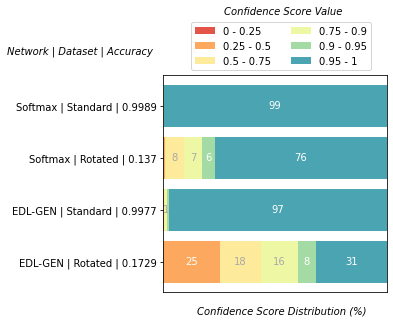

In [23]:
plot(conf_scores, accuracies, category_names, labels)
plt.savefig('sudoku_4x4_confidence.pdf', format='pdf', bbox_inches='tight')
plt.show()